Import MNIST dataset from Scikit-Learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Load dataset for digits

In [2]:
from sklearn.datasets import load_digits
data_digits = load_digits()

Each element represents the pixel of a greyscale image.

In [3]:
data_digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Show first 10 images

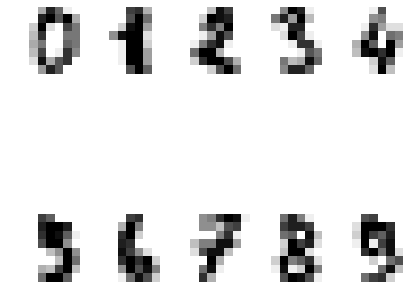

In [4]:
images_and_labels=list(zip(data_digits.images,data_digits.target))
plt.figure(figsize=(7,7))
for index,(image,label) in enumerate(images_and_labels[:10]):
    plt.subplot(2,5,index+1)
    plt.axis('off')
    plt.imshow(image,cmap=plt.cm.gray_r,interpolation='nearest')

In [5]:
n_samples_digits=len(data_digits.images)
X=data_digits.images.reshape((n_samples_digits,-1))
y=data_digits.target

In [6]:
print("Number of samples: "+ str(n_samples_digits))
print("Shape of input matrix X: "+str(X.shape))
print("Shape of target vector y: "+str(y.shape))

Number of samples: 1797
Shape of input matrix X: (1797, 64)
Shape of target vector y: (1797,)


Split data set to training, validadation and testing sets

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

The output model will have 10 units

In [9]:
X_train=X_train.T
X_val=X_val.T
y_train=y_train.reshape(y_train.shape[0],1)
y_val=y_val.reshape(y_val.shape[0],1)
y_train=y_train.T
y_val=y_val.T

Y_train_=np.zeros((10,y_train.shape[1]))
for i in range(y_train.shape[1]):
    Y_train_[y_train[0,i],i]=1
    
    
y_val_=np.zeros((10,y_val.shape[1]))
for i in range(y_val.shape[1]):
    y_val_[y_val[0,i],i]=1

n_x=X_train.shape[0]
n_h=10
n_y=Y_train_.shape[0]

Initialize parameters

In [10]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) 
    for l in range(1, L):
        parameters['w' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
    return parameters

Forward propagation

In [11]:
def linear_forward(x, w, b):
    Z = np.dot(w,x)+b
    cache = (x, w, b)
    
    return Z, cache

Activation functions and their derivatives

In [12]:
def sigmoid_(Z):
    return 1/(1+np.exp(-Z))

def ReLU_(Z):
    return Z*(Z>0)

def dReLU_(Z):
    return 1. *(Z>0)

def dsigmoid_(Z):
    return sigmoid_(Z)*(1-sigmoid_(Z))

def sigmoid(Z):
    return sigmoid_(Z),Z

def ReLU(Z):
    return ReLU_(Z),Z

### Forward propagation:
If the type of activation is sigmoid, it performs sigmoid activation function else performs ReLU activation function.

In [13]:
def linear_activation_forward(x_prev,w,b,activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(x_prev,w,b)
        x, activation_cache = sigmoid(Z)
        
    elif activation == "ReLU":
        Z, linear_cache = linear_forward(x_prev,w,b)
        x, activation_cache = ReLU(Z)
        
    cache = (linear_cache, activation_cache)
    
    return x, cache

Forward propagation for all layers in the network

In [14]:
def L_model_forward(X, parameters):
    caches = []
    x = X
    L = len(parameters) // 2   
    for l in range(1, L):
        x_prev = x 
        x, cache = linear_activation_forward(x_prev,parameters['w'+str(l)],parameters['b'+str(l)],"ReLU")
        caches.append(cache)
    xL, cache = linear_activation_forward(x,parameters['w'+str(L)],parameters['b'+str(L)],"sigmoid")
    caches.append(cache)
    return xL, caches

Cost function for the output AL:

In [15]:
def compute_cost(xL, Y):
    m=Y.shape[1]
    cost = -(1/m)*np.sum((Y*np.log(xL)+(1-Y)*np.log(1-xL)))
    cost=np.squeeze(cost)
    return cost

Backpropagation

In [16]:
def linear_backward(dZ, cache):
    x_prev, w, b = cache
    m = x_prev.shape[1]
    dw = (1/m)*np.dot(dZ,x_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dx_prev = np.dot(w.T,dZ)
    
    return dx_prev, dw, db

Activation functions for  ReLU layer and for sigmoid layer

In [17]:
def ReLU_backward(dx,activation_cache):
    return dx* dReLU_(activation_cache)

def sigmoid_backward(dx,activation_cache):
    return dx* dsigmoid_(activation_cache)

Overall backward propagation function for one layer

In [18]:
def linear_activation_backward(dx, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "ReLU":
        dZ = ReLU_backward(dx,activation_cache)
        dx_prev, dw, db = linear_backward(dZ,linear_cache)
    
    if activation == "sigmoid":
        dZ = sigmoid_backward(dx,activation_cache)
        dx_prev, dw, db = linear_backward(dZ,linear_cache)
    return dx_prev,dw,db

 Backward propagation for all layers

In [19]:
def L_model_backward(xL, Y, caches):
    grads = {}
    L = len(caches)
    m = xL.shape[1]
    
    dxL = - (np.divide(Y, xL) - np.divide(1 - Y, 1 - xL))
    
    current_cache = caches[L-1]
    grads["dx" + str(L-1)], grads["dw" + str(L)], grads["db" + str(L)] = linear_activation_backward(dxL,current_cache,"sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dx_prev_temp, dw_temp, db_temp = linear_activation_backward(grads["dx"+str(l+1)],current_cache,"ReLU")
        grads["dx" + str(l)] = dx_prev_temp
        grads["dw" + str(l + 1)] = dw_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

Adjust the weights using computed derivatives

In [20]:
def update_weights(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["w" + str(l+1)] = parameters["w" + str(l+1)]-(learning_rate)*grads["dw"+str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-(learning_rate)*grads["db"+str(l+1)]
    return parameters

N layer neural network

In [21]:
layers_dims=[n_x,60,10,10]

def L_layer_model(X, Y, layers_dims, learning_rate = 0.005, num_iterations = 100000, print_cost=False):
    np.random.seed(1)
    costs = [] 
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        xL, caches = L_model_forward(X, parameters)
        cost = compute_cost(xL, Y)
        grads = L_model_backward(xL, Y, caches)
        parameters = update_weights(parameters, grads, learning_rate)
        if print_cost and i % 1000 == 0:
            print ("Cost after %i iterations: %f" %(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
        if cost < 0.1:
            break
    
    return parameters

### Training

In [22]:
parameters = L_layer_model(X_train, Y_train_, layers_dims, num_iterations = 100000, print_cost = True)

Cost after 0 iterations: 6.931433
Cost after 1000 iterations: 3.774829
Cost after 2000 iterations: 3.262610
Cost after 3000 iterations: 3.249175
Cost after 4000 iterations: 3.248149
Cost after 5000 iterations: 3.245551
Cost after 6000 iterations: 3.234484
Cost after 7000 iterations: 3.108940
Cost after 8000 iterations: 2.714129
Cost after 9000 iterations: 2.217460
Cost after 10000 iterations: 1.924373
Cost after 11000 iterations: 1.561357
Cost after 12000 iterations: 1.231272
Cost after 13000 iterations: 0.951040
Cost after 14000 iterations: 0.764662
Cost after 15000 iterations: 0.618042
Cost after 16000 iterations: 0.489283
Cost after 17000 iterations: 0.401840
Cost after 18000 iterations: 0.339931
Cost after 19000 iterations: 0.289097
Cost after 20000 iterations: 0.243822
Cost after 21000 iterations: 0.203796
Cost after 22000 iterations: 0.171250
Cost after 23000 iterations: 0.145861
Cost after 24000 iterations: 0.126011
Cost after 25000 iterations: 0.109966


In [27]:
def predict_L_layer(X,parameters):
    xL,caches=L_model_forward(X,parameters)
    prediction=np.argmax(xL,axis=0)
    return prediction.reshape(1,prediction.shape[0])

In [28]:
predictions_train_L = predict_L_layer(X_train, parameters)
print("Training Accuracy : "+ str(np.sum(predictions_train_L==y_train)/y_train.shape[1] * 100)+" %")

Training Accuracy : 99.30410577592205 %


In [29]:
predictions_test_L=predict_L_layer(X_val,parameters)
print("Testing Accuracy : "+ str(np.sum(predictions_test_L==y_val)/y_val.shape[1] * 100)+" %")

Testing Accuracy : 95.83333333333334 %


<Figure size 432x288 with 0 Axes>

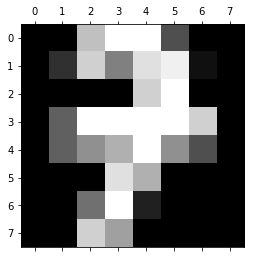

Predicted digit is : [[7]]
True digit is: 7


<Figure size 432x288 with 0 Axes>

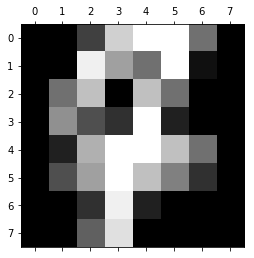

Predicted digit is : [[7]]
True digit is: 7


<Figure size 432x288 with 0 Axes>

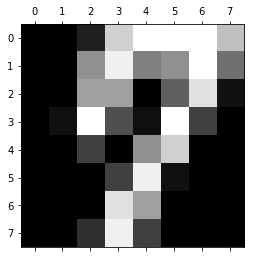

Predicted digit is : [[7]]
True digit is: 7


<Figure size 432x288 with 0 Axes>

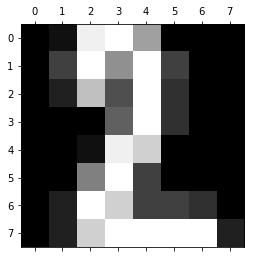

Predicted digit is : [[2]]
True digit is: 2


<Figure size 432x288 with 0 Axes>

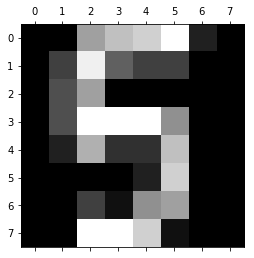

Predicted digit is : [[5]]
True digit is: 5


<Figure size 432x288 with 0 Axes>

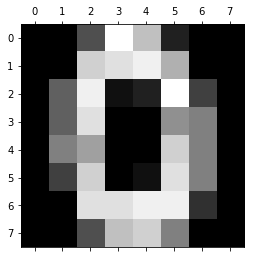

Predicted digit is : [[0]]
True digit is: 0


<Figure size 432x288 with 0 Axes>

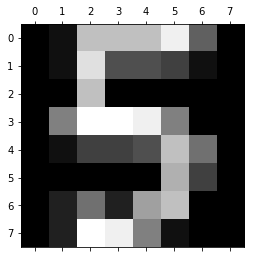

Predicted digit is : [[5]]
True digit is: 5


In [30]:
import random
import pylab as pl

for j in range(7):
    i=random.randint(0,n_samples_digits)
    pl.gray()
    pl.matshow(data_digits.images[i])
    pl.show()
    img=data_digits.images[i].reshape((64,1)).T
    img = sc.transform(img)
    img=img.T
    predicted_digit=predict_L_layer(img,parameters)
    print('Predicted digit is : '+str(predicted_digit))
    print('True digit is: '+ str(y[i]))